In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import datetime
import yfinance as yf
import threading
import scipy.optimize as sco
from pylab import mpl, plt
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def stock_adjclose(Tickers, start_y = 1900, start_m = 1, start_d = 1, end_y = 2040, end_m = 12, end_d = 31):
    start = datetime.datetime(start_y, start_m, start_d).strftime("%Y-%m-%d")
    end = datetime.datetime(end_y, end_m, end_d).strftime("%Y-%m-%d")
    data = yf.download(Tickers, start, end)
    data = data['Adj Close']
    data = data.round(decimals=2) 
    return data

def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

def min_func_sharpe(weights):  
    return -port_ret(weights) / port_vol(weights)

def min_func_return(weights):  
    return -port_ret(weights)

In [3]:
Betterment = ['VTI','VTV','VOE','VBR','VEA','VWO','AGG','MUB','VTIP','JNK','SHV','BNDX','EMB']
WiseBanyan= ["VEA", "VWO", "VGIT", "VGSH", "LQD", "VCSH", "SJNK", "TIP", "VNQ", "XME", "PICK", "FDN", "XLK", "VDC", "TFI", "VB", "VV", "ICLN", "QCLN", "VHT", "CGW", "PIO", "XLU", "XHB", "ITB", "HACK", "VFH", "XOP", "IEO"]
Charles_Schwab = symbols = ['SCHX', 'FNDX', 'SCHA', 'FNDA', 'SCHF', 'FNDF', 'SCHC', 'FNDC', 'SCHE', 'FNDE', 'SCHH', 'HAUZ', 'SCHD', 'MLPA','SCHR', 'SPIB', 'VMBS', 'SCHP', 'BNDX', 'EBND', 'PSK', 'BKLN', 'TFI', 'CMF', 'IAU']

In [4]:
noa_list = [len(Betterment), len(WiseBanyan), len(Charles_Schwab)]
name_list = ["Betterment", "WiseBanyan", "Charles_Schwab"]
data_Betterment = stock_adjclose(Betterment, 2015, 3, 31, 2020, 3, 31)
data_WiseBanyan = stock_adjclose(WiseBanyan, 2015, 3, 31, 2020, 3, 31)
data_Charles_Schwab = stock_adjclose(Charles_Schwab, 2015, 3, 31, 2020, 3, 31)
data_list = [data_Betterment, data_WiseBanyan, data_Charles_Schwab]

[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  29 of 29 completed
[*********************100%***********************]  25 of 25 completed


In [6]:
trets_list = []
tvols_list = []
for i in range(3):
    #print(i)
    rets = np.log(data_list[i] / data_list[i].shift(1)).dropna()
    weights = (np.random.random(noa_list[i]))
    
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = tuple((0, 1) for x in range(noa_list[i]))
    eweights = np.array(noa_list[i] * [1. / noa_list[i],])
    
    opts = sco.minimize(min_func_sharpe, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons, options = {"maxiter" : 100000})
    
    optr = sco.minimize(min_func_return, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons, options = {"maxiter" : 100000})
    
    optv = sco.minimize(port_vol, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons, options = {"maxiter" : 100000})
    
    cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = tuple((0, 1) for x in weights)
    #print(port_ret(optv['x']).round(3), port_ret(optr['x']).round(3))
    trets = np.linspace(port_ret(optv['x']).round(3), port_ret(optr['x']).round(3), 30)
    trets_list.append(trets)
    tvols = []
    for tret in trets:
        res = sco.minimize(port_vol, eweights, method='SLSQP',
                           bounds=bnds, constraints=cons, options = {"maxiter" : 100000})  
        tvols.append(res['fun'])
    tvols = np.array(tvols)
    tvols_list.append(tvols)

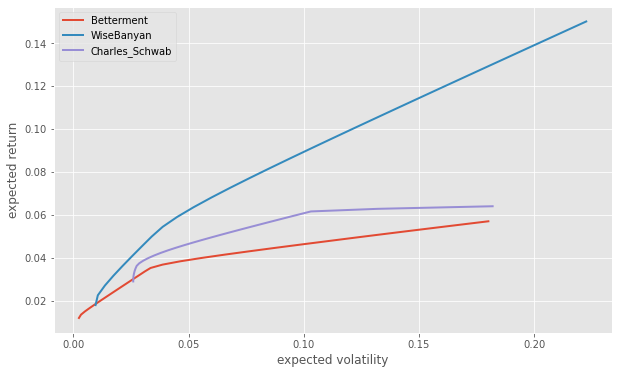

In [7]:
plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(tvols_list[i], trets_list[i], '-', lw=2.0, alpha=1, label = name_list[i])
    
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.legend()
plt.savefig('Compare.png')